In [2]:
import h5py

# Open the HDF5 file
train_path = r'/content/drive/MyDrive/Deep Learning/Tr.h5'
with h5py.File(train_path, 'r') as file:
    # Recursively print the structure of the file
    def print_structure(name, obj):
        if isinstance(obj, h5py.Group):
            print(f"Group: {name}")
        elif isinstance(obj, h5py.Dataset):
            print(f"Dataset: {name} - Shape: {obj.shape} - Data type: {obj.dtype}")

    file.visititems(print_structure)

Dataset: images - Shape: (250, 128, 128, 3) - Data type: uint8
Dataset: labels - Shape: (250,) - Data type: int32


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
import h5py

# Open the HDF5 file
test_path = r'/content/drive/MyDrive/Deep Learning/Te.h5'
with h5py.File(train_path, 'r') as file:
    # Recursively print the structure of the file
    def print_structure(name, obj):
        if isinstance(obj, h5py.Group):
            print(f"Group: {name}")
        elif isinstance(obj, h5py.Dataset):
            print(f"Dataset: {name} - Shape: {obj.shape} - Data type: {obj.dtype}")

    file.visititems(print_structure)

Dataset: images - Shape: (250, 128, 128, 3) - Data type: uint8
Dataset: labels - Shape: (250,) - Data type: int32


In [ ]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

def load_dataset():
    train_dataset = h5py.File('Tr.h5', "r")
    train_set_x_orig = np.array(train_dataset["images"][:])  # your train set features
    train_set_y_orig = np.array(train_dataset["labels"][:])  # your train set labels

    test_dataset = h5py.File('Te.h5', "r")
    test_set_x_orig = np.array(test_dataset["images"][:])  # your test set features
    test_set_y_orig = np.array(test_dataset["labels"][:])  # your test set labels

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig

def preprocess_data(X, Y, num_classes):
    X = X / 255.0  # Normalize pixel values
    Y = np.eye(num_classes)[Y.reshape(-1)]  # One-hot encoding
    return X, Y

train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig = load_dataset()

# Preprocess the data
num_classes = 5
train_x, train_y = preprocess_data(train_set_x_orig, train_set_y_orig, num_classes)
test_x, test_y = preprocess_data(test_set_x_orig, test_set_y_orig, num_classes)

# Flatten the data
train_x_flatten = train_x.reshape(train_x.shape[0], -1).T
test_x_flatten = test_x.reshape(test_x.shape[0], -1).T


In [ ]:
def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)


In [ ]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = -np.sum(np.multiply(Y, np.log(AL))) / m
    return np.squeeze(cost)


In [ ]:
def initialize_parameters_deep(layer_dims):
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

    return parameters

def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    return Z

def linear_activation_forward(A_prev, W, b, activation):
    Z = linear_forward(A_prev, W, b)
    if activation == "relu":
        A = np.maximum(0, Z)
    elif activation == "softmax":
        A = softmax(Z)
    return A, Z

def L_model_forward(X, parameters):
    A = X
    L = len(parameters) // 2
    caches = []

    for l in range(1, L):
        A_prev = A
        A, Z = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], "relu")
        caches.append((A_prev, parameters['W' + str(l)], parameters['b' + str(l)], Z))

    AL, ZL = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], "softmax")
    caches.append((A, parameters['W' + str(L)], parameters['b' + str(L)], ZL))

    return AL, caches

def linear_backward(dZ, A_prev, W, b):
    m = A_prev.shape[1]
    dW = np.dot(dZ, A_prev.T) / m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    dA_prev = np.dot(W.T, dZ)
    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):
    A_prev, W, b, Z = cache

    if activation == "relu":
        dZ = np.array(dA, copy=True)
        dZ[Z <= 0] = 0
    elif activation == "softmax":
        dZ = dA

    dA_prev, dW, db = linear_backward(dZ, A_prev, W, b)
    return dA_prev, dW, db

def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]

    dAL = AL - Y

    current_cache = caches[-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "softmax")

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+2)], current_cache, "relu")
        grads["dA" + str(l+1)] = dA_prev_temp
        grads["dW" + str(l+1)] = dW_temp
        grads["db" + str(l+1)] = db_temp

    return grads

def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2

    for l in range(L):
        parameters["W" + str(l+1)] -= learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] -= learning_rate * grads["db" + str(l+1)]

    return parameters


In [ ]:
def L_layer_model(X, Y, layers_dims, learning_rate, num_iterations, print_cost):
    np.random.seed(1)
    costs = []
    parameters = initialize_parameters_deep(layers_dims)

    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)

        if print_cost and i % 100 == 0:
            print(f"Cost after iteration {i}: {cost}")
        if i % 100 == 0:
            costs.append(cost)

    plt.plot(np.squeeze(costs))
    plt.ylabel('Cost')
    plt.xlabel('Iterations (per hundreds)')
    plt.title(f"Learning rate = {learning_rate}")
    plt.show()

    return parameters

In [ ]:
def predict(X, parameters):
    AL, _ = L_model_forward(X, parameters)
    predictions = np.argmax(AL, axis=0)
    return predictions

Cost after iteration 0: 1.6095547093839042
Cost after iteration 100: 1.6091701627705748
Cost after iteration 200: 1.6086869859206043
Cost after iteration 300: 1.6077855848300495
Cost after iteration 400: 1.6056416212932845
Cost after iteration 500: 1.598757233942481
Cost after iteration 600: 1.571657238981417
Cost after iteration 700: 1.5137292677599257
Cost after iteration 800: 1.410249209350955
Cost after iteration 900: 1.1863162367684497
Cost after iteration 1000: 0.9721459264638559
Cost after iteration 1100: 0.8260777682607656
Cost after iteration 1200: 0.5453117872983728
Cost after iteration 1300: 0.4681780247748502
Cost after iteration 1400: 0.3052504398571996
Cost after iteration 1500: 1.1713654145435521
Cost after iteration 1600: 0.18758927166466097
Cost after iteration 1700: 1.400851633774586
Cost after iteration 1800: 0.07755786076005307
Cost after iteration 1900: 0.05168582655821546
Cost after iteration 2000: 0.03419712408979455
Cost after iteration 2100: 0.02416325867240960

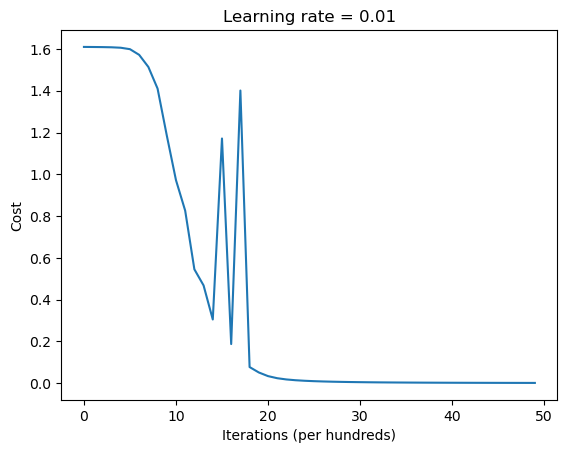

In [ ]:
layers_dims = [train_x_flatten.shape[0], 64, 32,5]
parameters = L_layer_model(train_x_flatten, train_y.T, layers_dims, learning_rate=0.01, num_iterations=5000, print_cost=True)

In [ ]:
train_pred = predict(train_x_flatten, parameters)
test_pred = predict(test_x_flatten, parameters)

train_accuracy = np.mean(train_pred == np.argmax(train_y, axis=1)) * 100
test_accuracy = np.mean(test_pred == np.argmax(test_y, axis=1)) * 100

print(f"Train Accuracy: {train_accuracy}%")
print(f"Test Accuracy: {test_accuracy}%")

Train Accuracy: 100.0%
Test Accuracy: 38.0%
